# Multiple linear regression model
**Here is how the equation looks**
>ΔR=β0​+β1​(Commercial Airbnb Listings)+β2​(Population Density)+β3​(Distance to Centre)+β4​(Deprivation)+ϵ
>
>Explanation:
>β0\beta_0β0​: Intercept (baseline rental price change when all predictors are zero).
β1,β2,β3,β4\beta_1, \beta_2, \beta_3, \beta_4β1​,β2​,β3​,β4​: Coefficients representing the effect of each predictor on rental price changes.
ϵ\epsilonϵ: Error term that captures variability in ΔR\Delta RΔR not explained by the predictors.



In [2]:
# load packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, linkage
from dateutil.relativedelta import relativedelta
from datetime import datetime
from PIL import Image
from io import BytesIO
from shapely.geometry import Point
from urllib.parse import urlparse

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

In [3]:
import pandas as pd

# Reading the data
df_rentalprice = pd.read_csv("https://github.com/a-saveleva/FSDS_Slap/blob/main/private_Rent/onsrents.csv?raw=true")

# Filtering for London boroughs based on Area Code
df_london = df_rentalprice[df_rentalprice['Area code'].str.startswith('E09')]

# Resetting the index of the filtered DataFrame
df_london = df_london.reset_index(drop=True)

# Ensure 'Time period' is in datetime format
df_london['Time period'] = pd.to_datetime(df_london['Time period'], errors='coerce')

# Define the start and end dates of the financial year 2022-223
start_date_2022 = pd.to_datetime("2022-04-01")
end_date_2022 = pd.to_datetime("2023-03-31")

# Filter for the 2022-23 financial year
filtered_rents_2022 = df_london[(df_london['Time period'] >= start_date_2022) & (df_london['Time period'] <= end_date_2022)]

# Grouping by Area code and Area name to calculate the average rental price for 2022-23
monthly_avg_rent_2022 = filtered_rents_2022.groupby(['Area code', 'Area name'])['Rental price'].mean().reset_index()

# Renaming the columns for clarity for 2022-23
monthly_avg_rent_2022.columns = ['Mnemonic', 'Borough Name', 'Average Rental Price 2022-23']

# Define the start and end dates of the financial year 2020-21
start_date_2023 = pd.to_datetime("2023-04-01")
end_date_2023 = pd.to_datetime("2024-03-31")

# Filter for the 2023-24 financial year
filtered_rents_2023 = df_london[(df_london['Time period'] >= start_date_2023) & (df_london['Time period'] <= end_date_2023)]

# Grouping by Area code and Area name to calculate the average rental price for 2020-21
monthly_avg_rent_2023 = filtered_rents_2023.groupby(['Area code', 'Area name'])['Rental price'].mean().reset_index()

# Renaming the columns for clarity for 2020-21
monthly_avg_rent_2023.columns = ['Mnemonic', 'Borough Name', 'Average Rental Price 2023-24']

# Merging the two datasets (2022-23 and 202-22) by 'Mnemonic' and 'Borough Name'
df_rental_comparison = pd.merge(monthly_avg_rent_2022, monthly_avg_rent_2023, on=['Mnemonic', 'Borough Name'], how='inner')


# Check for missing values in the merged DataFrame
print(df_rental_comparison.isnull().sum())

# Calculate the difference between the two financial years
df_rental_comparison['Price_Difference'] = df_rental_comparison['Average Rental Price 2023-24'] - df_rental_comparison['Average Rental Price 2022-23']

# Displaying the updated DataFrame
print(df_rental_comparison)



Mnemonic                        0
Borough Name                    0
Average Rental Price 2022-23    0
Average Rental Price 2023-24    0
dtype: int64
     Mnemonic            Borough Name  Average Rental Price 2022-23  \
0   E09000002    Barking and Dagenham                   1286.500000   
1   E09000003                  Barnet                   1534.916667   
2   E09000004                  Bexley                   1191.666667   
3   E09000005                   Brent                   1499.000000   
4   E09000006                 Bromley                   1373.833333   
5   E09000007                  Camden                   2169.333333   
6   E09000008                 Croydon                   1242.500000   
7   E09000009                  Ealing                   1590.416667   
8   E09000010                 Enfield                   1386.750000   
9   E09000011               Greenwich                   1500.583333   
10  E09000012                 Hackney                   1977.750000   

**Reading in the population density data**

In [4]:
df_censuspopdens = pd.read_csv("https://github.com/a-saveleva/FSDS_Slap/blob/main/census_data/Census_PopDensity.csv?raw=true", 
                                  skiprows = 6, nrows = 33 ,usecols = ['mnemonic', '2021'])

df_censuspopdens.rename(columns={'2021':'PopDensity'}, inplace=True)

# Mapping of mnemonic codes to borough names
mnemonic_to_borough = {
    'E09000001': 'City of London',
    'E09000002': 'Barking and Dagenham',
    'E09000003': 'Barnet',
    'E09000004': 'Bexley',
    'E09000005': 'Brent',
    'E09000006': 'Bromley',
    'E09000007': 'Camden',
    'E09000008': 'Croydon',
    'E09000009': 'Ealing',
    'E09000010': 'Enfield',
    'E09000011': 'Greenwich',
    'E09000012': 'Hackney',
    'E09000013': 'Hammersmith and Fulham',
    'E09000014': 'Haringey',
    'E09000015': 'Harrow',
    'E09000016': 'Havering',
    'E09000017': 'Hillingdon',
    'E09000018': 'Hounslow',
    'E09000019': 'Islington',
    'E09000020': 'Kensington and Chelsea',
    'E09000021': 'Kingston upon Thames',
    'E09000022': 'Lambeth',
    'E09000023': 'Lewisham',
    'E09000024': 'Merton',
    'E09000025': 'Newham',
    'E09000026': 'Redbridge',
    'E09000027': 'Richmond upon Thames',
    'E09000028': 'Southwark',
    'E09000029': 'Sutton',
    'E09000030': 'Tower Hamlets',
    'E09000031': 'Waltham Forest',
    'E09000032': 'Wandsworth',
    'E09000033': 'Westminster'
}

# Add a column for borough names
df_censuspopdens['Borough'] = df_censuspopdens['mnemonic'].map(mnemonic_to_borough)

# Display the updated DataFrame
#print(df_censuspopdens)


**Reading in the vacant homes data**

In [5]:
#https://data.london.gov.uk/download/vacant-dwellings/c428a18b-9961-4b98-9cfe-b7f120114141/vacant-dwellings-borough%20%282%29.xlsx
df_vacantprops = pd.read_excel("https://data.london.gov.uk/download/vacant-dwellings/c428a18b-9961-4b98-9cfe-b7f120114141/vacant-dwellings-borough%20%282%29.xlsx", 
                                  sheet_name = 2, skiprows = 1, nrows = 34)

#df_vacantprops.dropna(inplace = True)
#df_vacantprops.shape

df_vacantprops.rename(columns={'Unnamed: 0':'LAcode'}, inplace=True)
df_vacantprops.rename(columns={'Unnamed: 1':'LAname'}, inplace=True)

#df_vacantprops.dtypes

df_vacantprops.dropna(inplace=True)

print(df_vacantprops)


       LAcode                  LAname    2004    2005    2006    2007    2008  \
1   E09000001          City of London   119.0    86.0    55.0    54.0    47.0   
2   E09000002    Barking and Dagenham   434.0   513.0   893.0  1181.0   750.0   
3   E09000003                  Barnet  1654.0  1805.0  1604.0  1576.0  1704.0   
4   E09000004                  Bexley   898.0   932.0   823.0   911.0   756.0   
5   E09000005                   Brent  1294.0  1231.0  1214.0  1162.0   830.0   
6   E09000006                 Bromley  1506.0  1437.0  1253.0  1138.0  1047.0   
7   E09000007                  Camden  1503.0  1338.0  1056.0  1079.0  1125.0   
8   E09000008                 Croydon  2978.0  2049.0  2721.0  1822.0  1640.0   
9   E09000009                  Ealing  1215.0  1179.0  1091.0  1131.0  1144.0   
10  E09000010                 Enfield  2848.0  2661.0  3028.0  1551.0   905.0   
11  E09000011               Greenwich  1314.0  1362.0  1510.0  1406.0  1466.0   
12  E09000012               

**Reading in the tenure data**

In [6]:
df_censusTenure = pd.read_csv("https://github.com/a-saveleva/FSDS_Slap/blob/main/census_data/Census_Tenure.csv?raw=true", 
                                  skiprows = 6, nrows = 33, usecols = ['mnemonic', 'Owned', 'Shared ownership',
                                                                      'Social rented', 
                                                                       'Private rented or lives rent free'])

#calculating the proportions of owned and rented 
df_censusTenure['Rented'] = df_censusTenure[['Shared ownership', 'Social rented', 'Private rented or lives rent free']].sum(axis=1)

#creating a composite variable 
df_censusTenure['Owned_to_Rented_Ratio'] = df_censusTenure['Owned'] / df_censusTenure['Rented']
#to assess how changes in the proportion of owned versus rented properties influence rental price changes.

print(df_censusTenure)

     mnemonic  Owned  Shared ownership  Social rented  \
0   E09000002   42.4               1.7           31.5   
1   E09000003   52.7               1.1           13.5   
2   E09000004   68.6               1.3           14.7   
3   E09000005   38.4               1.9           23.5   
4   E09000006   68.5               0.9           13.2   
5   E09000007   29.7               0.8           33.7   
6   E09000001   36.5               0.2           14.9   
7   E09000008   54.7               1.4           17.9   
8   E09000009   46.2               2.0           17.5   
9   E09000010   52.4               1.1           17.0   
10  E09000011   41.1               2.2           31.0   
11  E09000012   24.6               2.5           40.5   
12  E09000013   32.1               1.5           29.8   
13  E09000014   37.2               1.6           25.2   
14  E09000015   58.8               1.1           10.4   
15  E09000016   69.5               1.0           13.6   
16  E09000017   56.6           

**reading airbnb data and calculating how many listings were vacant for 36 days**

In [7]:
#| echo: false
def cache_data(src:str) -> str:
    """Downloads and caches a remote file locally.
    src : str - The remote *source* for the file, any valid URL should work.
    dest : str - The *destination* location to save the downloaded file.    
    Returns a string representing the local location of the file.
    """
    dest = os.path.join('data','raw') #destination to save data
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn = (url.path.split('/')[-3])+(url.path.split('/')[-1]) # return the file name with date
    dfn = os.path.join(dest,fn) # Destination filename
    print(f"Writing to: {fn}")

    if not os.path.isfile(dfn) or os.stat(dfn).st_size < 250:
        
        print(f"{dfn} not found or corrupted, downloading!")
        path = os.path.split(dest)
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            # Download and save the file #os.path.join(*path)
            try:
                with open(dfn, "wb") as file:
                    response = requests.get(src)
                    response.raise_for_status()  # Raise an exception for HTTP errors
                    file.write(response.content)
                print("\tDone downloading.")
            except Exception as e:
                print(f"Error: {e}")
                
        f_size = os.stat(dfn).st_size
        print(f"\tSize is {f_size/1024**2:,.0f} MB ({f_size:,} bytes)")
    else:
        print(f"Found {dfn} locally!")
        f_size = os.stat(dfn).st_size
        print(f"\tSize is {f_size/1024**2:,.0f} MB ({f_size:,} bytes)")
        
    return dfn

In [8]:
#| echo: false
#_____________________________________________________________________________________________________________________________
# Set download URL for London data the date should be choosen by reviewing 
# the InsideAirbnb Get Data page and identifying the date of the required data
# We are using the 2 datasets with earliest and latest scrape of those available
#_____________________________________________________________________________________________________________________________
airbnbdates  = ["2023-12-10", "2024-09-06"]
airbnbcols = ['id', 'listing_url', 'picture_url', 'host_id', 'host_listings_count',
              'host_total_listings_count', 'property_type', 'room_type', 'price', 
              'minimum_nights', 'maximum_nights', 'availability_365', 
              'number_of_reviews', 'latitude', 'longitude', 'last_review', 
              'beds', 'bedrooms']
airbnbdfs = []
for date in airbnbdates:
    airbnburl  = f"https://data.insideairbnb.com/united-kingdom/england/london/{date}/data/listings.csv.gz"
    dfn = cache_data(airbnburl)
    airbnbdfs.append(pd.read_csv(dfn, low_memory=False,usecols=airbnbcols))
   
airbnb_dflist = [airbnb_old, airbnb_new] = airbnbdfs #airbnb_old is the earlier scrape, and new is the later scrape. We don't hardcode the dates for reproducibility with other dates and times.

airbnb_gdfs = []
for df in airbnb_dflist:
#_____________________________________________________________________________________________________________________________
#   I convert the df into gdf, reproject into EPSG 27700
#_____________________________________________________________________________________________________________________________  
    df = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs='EPSG:4326')
    
    df = df.set_crs('EPSG:4326', allow_override=True)
    df.to_crs('EPSG:27700', inplace=True)
    airbnb_gdfs.append(df)

Writing to: 2023-12-10listings.csv.gz
Found data/raw/2023-12-10listings.csv.gz locally!
	Size is 31 MB (32,102,141 bytes)
Writing to: 2024-09-06listings.csv.gz
Found data/raw/2024-09-06listings.csv.gz locally!
	Size is 48 MB (50,734,149 bytes)


In [9]:
#| echo: false
#_____________________________________________________________________________________________________________________________
# InsideAirbnb data cleaning. We first define the functions to be used in cleaning.
#_____________________________________________________________________________________________________________________________
def pick_active_listings(df, date='str', col="str"):
    """
    Converting review column to datetime, and selecting only the recently active listings. 
    Recently active is defined as those which received at least one review for the year precedeng the scrape.
    Arguments:
    date: string, format "%Y-%m-%d"
    dataframe
    col: string, colname with "last_review" or its alternative
    """
    df.loc[:, col] = pd.to_datetime(df[col])
    date = datetime.strptime(date, "%Y-%m-%d")
    df = df[df['last_review'] > (date - relativedelta(years=1))] #| (df['last_review'].isnull())]
    
    print(f"Data frame after filtering last review date is {df.shape[0]:,} x {df.shape[1]} long.")
    return df

In [10]:
#| echo: false
#_____________________________________________________________________________________________________________________________
# Why do we remove duplicates?
# In the regression part of our analysis, we  want to calculate N of homes that are somehow involved in Airbnb listings, and therefore don't fulle realise it's potential on traditional rental/housing market.
# If we took just listing locations, with the amount of duplicates that we found, the N would show ACTIVITY of hosts more than loss of homes for housing market.
# ChatGPT was used here to determine clustering methods, and for debugging.
#_____________________________________________________________________________________________________________________________

def find_duplicates(df_valid):
    """
    The function looks at hosts with multiple listings and checks if they are within 300m radius (150m max location scattering as per Airbnb's anonymisation algorithm, x2).
    It then estimates the number of genuine homes within the cluster.
    
    Returns a gdf with new columns: 
    'cluster_id' - each unique value is a cluster
    'easting', 'northing' - used in calculating the proximity of listings
    'prvt_rms_in_cluster','entr_hms_in_cluster' - summarises N of private rooms and entire homes within the cluster
    'genuine', 'true_nrooms' - boolean column, and int column, with the following assumptions:

    If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded. 
    The location of the point will be amended to represent centrepoint of all rooms in the cluster.
    Record of the N of rooms will stay in col "true_nrooms"
    If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home. 
    With the current timeframes, further enquiries into uniqueness of homes vs rooms inside each cluster is not feasible.
    """
    
    df['easting'], df['northing'] = df.geometry.x, df.geometry.y #this is needed for the clustering  
#_____________________________________________________________________________________________________________________________
#   We are looking for duplicates among multi-listing hosts. First, we filter by new_listings_count > 1.
#_____________________________________________________________________________________________________________________________
    finddups = df_valid[df_valid['new_host_listings_count'] > 1]
    print(f"There are {finddups.shape[0]:,} listings from multi-listing hosts.")
#_____________________________________________________________________________________________________________________________
#   I perform cluster analysis a1nd mark listings from the same host that are within 300m from each other 
#   (150m max location scattering as per Airbnb's anonymisation algorithm, x2). They constitute a cluster, and we then assess if they are a duplicate or not.
#   The selected method computes pairwise distances  can calculate the distance matrix between all points in a group. 
#   Before this method I tried KNN, but the listings were paired incorrectly. 
#   cdist solved this, and it is relatively light on small groups (our dataset is large, but it is split into small groups - by host).
#
#   It is possible, that listings outside clusters also could be in one entire home. E.g. there could be several hosts registered for one home.
#   We acknowledge this gap, and advise this for further research.
#_____________________________________________________________________________________________________________________________
    # Process each host group
    for host_id, group in finddups.groupby("host_id"):
        if len(group) > 1:  # Only proceed if there is more than 1 listing
            coords = group[['easting', 'northing']].to_numpy()
            
            # Calculate pairwise distances using pdist (returns condensed distance matrix)
            dist_matrix = pdist(coords)
            
            # Perform hierarchical clustering using the condensed distance matrix
            linkage_matrix = linkage(dist_matrix, method='single')
            clusters = fcluster(linkage_matrix, t=300, criterion='distance')
            
            # Create a series to count cluster sizes
            cluster_sizes = pd.Series(clusters).value_counts()
    
            # Assign clusters to rows in the group, but only for clusters with more than one member - these will retain default column value of None
            finddups.loc[group.index, 'cluster_id'] = [
                f"{host_id}-{cluster}" if cluster_sizes[cluster] > 1 else None
                for cluster in clusters
            ]
#_____________________________________________________________________________________________________________________________
#   We create a subset with non-unique listings only to calculate true_nrooms and determine genuineness.
#   At the very end of the function, this subset is merged back into df_valid.
#_____________________________________________________________________________________________________________________________
    finddups1 = finddups[~finddups['cluster_id'].isna()]
    finddups1 = finddups1.loc[finddups.duplicated(subset='cluster_id', keep=False)]   
    print(f"Found {len(set(finddups1.cluster_id)):,} clusters.")   
#_____________________________________________________________________________________________________________________________
#   I calculate N of entire homes and rooms in each cluster.
#   Limitation found during EDA: "bedrooms" column in InsideAirbnb differs between scrapes. 
#   "2023-12-10" scrape has NaN values in this column, while "2024-09-06" scrape has full data.
#   For both datasets, we use "beds" column as a substitute, because airbnb2024.bedrooms.median()/airbnb2024.beds.median() = 1.
#_____________________________________________________________________________________________________________________________
    finddups1 = finddups.loc[finddups.duplicated(subset='cluster_id',keep=False)]
#   Loop through each cluster by cluster_id. 
    for i, group in finddups1.groupby("cluster_id"):
        # Count number of entire homes and private rooms in the group
        n_entire_homes = group[group['room_type'] == 'Entire home/apt'].shape[0]
        n_private_rooms = group[group['room_type'] == 'Private room'].shape[0]   
        # Assign these counts back to the original DataFrame
        finddups1.loc[group.index, 'entr_hms_in_cluster'] = n_entire_homes
        finddups1.loc[group.index, 'prvt_rms_in_cluster'] = n_private_rooms          
#_____________________________________________________________________________________________________________________________
#   I then determine whether listings are genuine unique homes, or rooms from one entire home.
#   If the cluster has 0 entire homes, and N rooms, first room will be "converted" to an entire home, and the rest will be discarded.
#   Record of the N of rooms will stay in col "true_nrooms".
#   If the cluster has rooms and entire homes, the homes will be treated as genuine homes, and rooms treated as duplicates of the genuine home.
#   It is possible that all entire homes in one cluster are absolutely identical, but with the methods employed we can go this far. We acknowledge the gap and suggest it for further research.
#_____________________________________________________________________________________________________________________________
    for cluster_id, group in finddups1.groupby("cluster_id"):
        
        num_entire_homes = (group['room_type'] == 'Entire home/apt').sum()
        if num_entire_homes == 0:
            # If only rooms are in the cluster
            finddups1.loc[group.index, 'genuine'] = False  # Mark all as duplicates
            finddups1.loc[group.index[0], 'genuine'] = True  # First room becomes the genuine home
#_____________________________________________________________________________________________________________________________
#           but the geometry is replaced with centroid x and y.  
#           Without this the point and all associated rooms can be aggregated by different spatial unit, considering the scale of the location approximation (up to 150m from origin).
#           This is not crucial for our research, because we aggregate by borough, and potential aggregation errors will be minimal. But for other research with smaller geospatial units it will prove more useful.
#_____________________________________________________________________________________________________________________________
            dissolved_geometry = group.geometry.union_all()  # Combine all geometries in the group
            centroid = dissolved_geometry.centroid # Get the centroid of the combined geometry
            finddups1.at[group.index[0], 'geometry'] = Point(centroid.x, centroid.y)
        else:
            # Cluster has both rooms and entire homes
            finddups1.loc[group.index, 'genuine'] = False  # Default all to duplicates
            entire_home_indices = group[group['room_type'] == 'Entire home/apt'].index
            finddups1.loc[entire_home_indices, 'genuine'] = True  # Mark entire homes with true

    print(f"The clustering exercise identified {len(finddups1[finddups1['genuine'] == False])} listings that are potentially duplicates of other listings.")
    df_valid.update(finddups1)
    
    return df_valid

In [11]:
#| echo: false
airbnb_gdf_clean = []
airbnb_gdf_ingenuine = []
airbnb_gdf_all = []

for df in airbnb_gdfs:
    print(f"Initial dataframe is {df.shape[0]:,} x {df.shape[1]} long.")
    df['price'] = df['price'].fillna('0').str.replace('$', '', regex=False).str.replace(',', '').astype(float).astype(int)
    df.drop(df[df["price"]==0].index, axis=0, inplace=True)
    print(f"Data frame after filtering invalid prices is {df.shape[0]:,} x {df.shape[1]} long.")
    
    df = pick_active_listings(df, date, "last_review")

    ints  = ['id', 'host_listings_count', 'host_id', 'bedrooms', 'beds', 
             'host_total_listings_count', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews']
    for i in ints:
        #print(f"Converting {i}")
        try:
            df.loc[:, i] = df[i].fillna(0).astype(float).astype(int)
        except ValueError as e:
            #print("  - !!!Converting to unsigned 16-bit integer!!!")
            df.loc[:, i] = df[i].fillna(0).astype(float).astype(pd.UInt16Dtype())
    #_____________________________________________________________________________________________________________________________
    # After these transformations, the N of listings for each host has changed. We dropped rows where listings were likely inactive at the time of the scrape.
    # We create a new column with host_listings_count, and calculate the counts using grouping by host_id.
    #_____________________________________________________________________________________________________________________________
    host_counts = df['host_id'].value_counts()
    df = pd.merge(df,host_counts,right_index=True,left_on='host_id').rename(columns={'count':'new_host_listings_count'})
        
    # null values in N of bedrooms will interfere with our analysis, therefore we drop them
    df = df[df['beds'].notna()]
    print(f"Data frame after cleaning invalid N of beds is {df.shape[0]:,} listings long.")
    
    # creating columns necessary for the analysis and filling with default values
    df['prvt_rms_in_cluster'] = df['beds'] #be are using beds for rooms, but for now just copy the column
    df['entr_hms_in_cluster'] = 0 #default will be 0
    df['cluster_id'] = None #will write ids here
    #df['true_nrooms'] = df['beds'] #estimation of true n of rooms proved inconclusive with the methods used. The parts related to rooms are commented out.
    df['genuine'] = True   
    
    dups = find_duplicates(df) 
    airbnb_gdf_all.append(dups)
    airbnb_gdf_ingenuine.append((dups[dups['genuine'] == False]).copy()) #collecting False for validation
    
    df = (df[df['genuine'] == True]).copy()
    df = df[(df['availability_365']) > (5.84*12)] #Filtering by "commercial" - rented out more than average per month for London. Average is 5.84 days

    print(f"Data frame after cleaning duplicate listings is {df.shape[0]:,} listings long.\n")
    
    airbnb_gdf_clean.append(df)

Initial dataframe is 91,778 x 19 long.
Data frame after filtering invalid prices is 87,598 x 19 long.
Data frame after filtering last review date is 32,549 x 19 long.
Data frame after cleaning invalid N of beds is 32,549 listings long.
There are 18,246 listings from multi-listing hosts.
Found 4,329 clusters.
The clustering exercise identified 4297 listings that are potentially duplicates of other listings.
Data frame after cleaning duplicate listings is 18,172 listings long.

Initial dataframe is 96,182 x 19 long.
Data frame after filtering invalid prices is 63,205 x 19 long.
Data frame after filtering last review date is 42,667 x 19 long.
Data frame after cleaning invalid N of beds is 42,667 listings long.
There are 25,512 listings from multi-listing hosts.
Found 5,871 clusters.
The clustering exercise identified 5643 listings that are potentially duplicates of other listings.
Data frame after cleaning duplicate listings is 28,207 listings long.



In [12]:
print(type(airbnb_gdf_clean))

<class 'list'>


In [17]:
airbnb_gdf_clean_df = airbnb_gdf_clean[1]  # Accsessing the first data frame in the list 
#    print(airbnb_gdf_clean_df.columns)


#print(airbnb_gdf_clean)

'''
 I am seperating the airbnb_gdf into two seperate data frames because you can't 
 run a spatial join on a list and this is becoming increasingly complicated so I am 
 just taking the easy way out 
'''

# seperating the data frames
airbnb_gdf_first = airbnb_gdf_clean[0]  # For example, the first DataFrame in the list
airbnb_gdf_second = airbnb_gdf_clean[1]  # For example, the second DataFrame in the list

# Now you have two separate DataFrames
print(airbnb_gdf_first.shape)

# Print the data type of airbnb_gdf_first
print(type(airbnb_gdf_first))



# Check the shape of the first DataFrame
print(airbnb_gdf_second.shape)  # Check the shape of the second DataFrame

print(airbnb_gdf_first)

(18172, 26)
<class 'geopandas.geodataframe.GeoDataFrame'>
(28207, 26)
                       id                                      listing_url  \
2                   42010               https://www.airbnb.com/rooms/42010   
4                   89870               https://www.airbnb.com/rooms/89870   
6                   96052               https://www.airbnb.com/rooms/96052   
13                 565770              https://www.airbnb.com/rooms/565770   
16                 501837              https://www.airbnb.com/rooms/501837   
...                   ...                                              ...   
91766  948610432421150080  https://www.airbnb.com/rooms/948610432421150114   
91767  948613911238301184  https://www.airbnb.com/rooms/948613911238301135   
91768  949031302847272448  https://www.airbnb.com/rooms/949031302847272399   
91775  951188392382129024  https://www.airbnb.com/rooms/951188392382129035   
91777  952607914901368448  https://www.airbnb.com/rooms/9526079149013684

In [14]:
#reading in the borough boundaries
cwd = os.getcwd()
boro_shp = os.path.join(cwd, "data", "london-boundaries", "statistical-gis-boundaries-london", "ESRI", "London_Borough_Excluding_MHW.shp")  
boro_gdf = gpd.read_file(boro_shp).to_crs('EPSG:27700')[['NAME', 'GSS_CODE', 'ONS_INNER', 'geometry']]

In [18]:
# Perform a spatial join on both data frames 
# Perform a spatial join for the first GeoDataFrame with borough boundaries
merged_first = gpd.sjoin(airbnb_gdf_first, boro_gdf, how='inner', predicate='within')  # "within" is the most common spatial operation

# Perform a spatial join for the second GeoDataFrame with borough boundaries
merged_second = gpd.sjoin(airbnb_gdf_second, boro_gdf, how='inner', predicate='within')

print(airbnb_gdf_first.crs, boro_gdf.crs)


EPSG:27700 EPSG:27700


In [19]:
#| echo: false
def airbnb_count(gdf, boro_gdf):
    """
    Function to count the airbnb locations within each borough and LSOA, split by room type.
    Args:
    gdf: airbnb gdf
    boro_gdf: geographic areas
    Both gdfs should be in the same projection.
    """ 
    #clip by London boundary
    gdf = gdf.clip(boro_gdf)
    
    # counts the airbnb locations within each borough, split by room type
    # set new gdf for each room type
    entire_ab_gdf = gdf[gdf['room_type'] == "Entire home/apt"]
    pr_ab_gdf = gdf[gdf['room_type'] == "Private room"]
    #other_ab_gdf = gdf[~gdf['room_type'].isin(["Entire home/apt", "Private room"])]
#_____________________________________________________________________________________________________________________________
#Due to the relatively low counts of "other" room types we can discount these from our analysis and focus 
#on "Entire Home/apts" and "Private rooms"
#_____________________________________________________________________________________________________________________________   
    # create point counts per borough
    c1 = boro_gdf.join(gpd.sjoin(gdf, boro_gdf).groupby("index_right").size().rename("total_airbnbs"))
    c2 = c1.join(gpd.sjoin(entire_ab_gdf, c1).groupby("index_right").size().rename("total_entireha"))
    boro_count_gdf = c2.join(gpd.sjoin(pr_ab_gdf, c2).groupby("index_right").size().rename("total_privateroom"))
    #boro_count_gdf = c3.join(gpd.sjoin(other_ab_gdf, c3).groupby("index_right").size().rename("total_other"))
    
    # replaces NaN values with zero
    ## could build funtion to iterate through this
    boro_count_gdf['total_entireha'] = boro_count_gdf['total_entireha'].fillna(0).astype('int64')
    boro_count_gdf['total_privateroom'] = boro_count_gdf['total_privateroom'].fillna(0).astype('int64')
    #boro_count_gdf['total_other'] = boro_count_gdf['total_other'].fillna(0).astype('int64')

    airbnb_count_boro = [boro_count_gdf, entire_ab_gdf, pr_ab_gdf
                         #,other_ab_gdf
                        ]
    
    return airbnb_count_boro

In [20]:
#| echo: false
def rel_prcnt_change_gdfs(gdf_old, gdf_new, cols):
    """
    Function to find different in number of listings between 2 dates.
    Args:
    gdf_old: earlier airbnb dataset
    gdf_new: latest airbnb dataset
    cols: specify a subset of columns to be substracted
    """
    #Verify that the geometry matches
    if not gdf_old.geometry.equals(gdf_new.geometry):
        raise ValueError("The geometries of the two GeoDataFrames do not match!")
    
    #Verify that the specified columns exist in both GeoDataFrames
    for col in cols:
        if col not in gdf_old.columns or col not in gdf_new.columns:
            raise ValueError(f"Column '{col}' does not exist in both GeoDataFrames.")
    
    #Create a copy of the new gdf to store the differences
    gdf_diff = gdf_new.copy()
    
    # Subtract the specified columns
    for col in cols:
        gdf_diff[col] = ((gdf_new[col] - gdf_old[col]) / gdf_old[col])*100
    
    # Ensure the geometry column is preserved
    gdf_diff['geometry'] = gdf_new['geometry']
    
    return gdf_diff

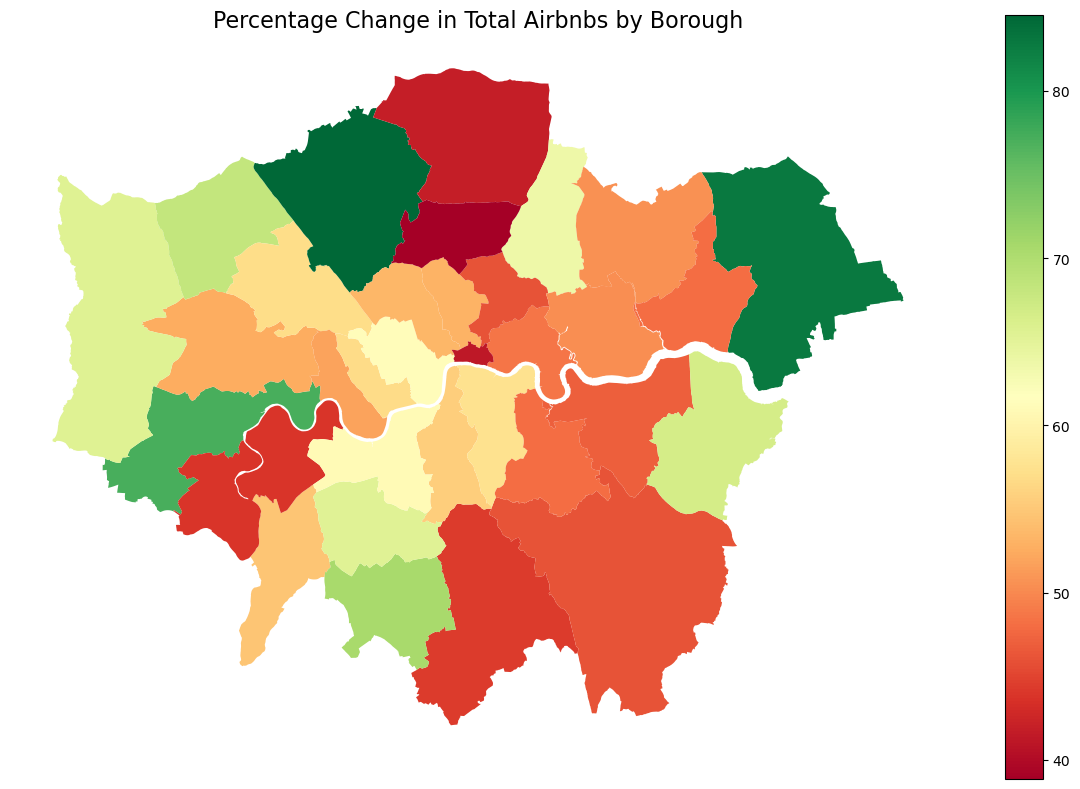

                      NAME   GSS_CODE ONS_INNER  \
0     Kingston upon Thames  E09000021         F   
1                  Croydon  E09000008         F   
2                  Bromley  E09000006         F   
3                 Hounslow  E09000018         F   
4                   Ealing  E09000009         F   
5                 Havering  E09000016         F   
6               Hillingdon  E09000017         F   
7                   Harrow  E09000015         F   
8                    Brent  E09000005         F   
9                   Barnet  E09000003         F   
10                 Lambeth  E09000022         T   
11               Southwark  E09000028         T   
12                Lewisham  E09000023         T   
13               Greenwich  E09000011         F   
14                  Bexley  E09000004         F   
15                 Enfield  E09000010         F   
16          Waltham Forest  E09000031         F   
17               Redbridge  E09000026         F   
18                  Sutton  E09

In [52]:
# Calculate counts per borough for both time periods
counts_first_gdf = airbnb_count(airbnb_gdf_first, boro_gdf)[0]
counts_second_gdf = airbnb_count(airbnb_gdf_second, boro_gdf)[0]

# Calculate percentage change
columns_to_compare = ['total_airbnbs', 'total_entireha', 'total_privateroom']
percentage_change_gdf = rel_prcnt_change_gdfs(counts_first_gdf, counts_second_gdf, columns_to_compare)

# Visualize the percentage change for total_airbnbs
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
percentage_change_gdf.plot(column='total_airbnbs', cmap='RdYlGn', legend=True, ax=ax)
ax.set_title('Percentage Change in Total Airbnbs by Borough', fontsize=16)
ax.set_axis_off()

# Save the result as an image or display it
plt.tight_layout()
plt.show()
#print(percentage_change_gdf)

print(counts_first_gdf)

In [ ]:

"""
Data on STL occupancy in London varies. Also, official occupancy cap does not sufficiently help describe "fair use" of Airbnb.
We use the data provided by ONS: The number of guest nights, nights, and stays for short-term lets offered through online collaborative 
economy platforms (Airbnb, Booking.com and Expedia Group). https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/guestnightsnightsandstaysforshorttermletsuk
Matched with Hosts, listings, and bed spaces of short-term lets, UK: 2023. https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/hostslistingsandbedspacesofshorttermletsuk2023
See more in text description of data cleaning and wrangling.

According to this data, in December 2023 (month where there is overlap between 2 datasets), there were 152,050 nights spent in all 111,880 observed STLs in London, 5.84 nights per listing.
We take this as a benchmark for "fair" use of Airbnb in London. Hosts that are available for longer than 5.84*12 days will be considereded as those taking advantage of the opportunity,
which also means there is a possibility that they don't live in the flat.
"""


In [28]:
from pyproj import Proj, Transformer
import geopandas as gpd
import numpy as np
import os

# Manually define latitudes and longitude finder from london uk 
lat_lon = [
    (51.5014, -0.1406),  # Buckingham Palace
    (51.5085, -0.0761),  # Tower of London
    (51.5184, -0.1270),  # British Museum
    (51.5007, -0.1246),  # Big Ben
    (51.5033, -0.1195)   # London Eye
]

# Reprojecting coordinates to BNG (EPSG:27700)
transformer = Transformer.from_crs("epsg:4326", "epsg:27700", always_xy=True)
eastings_northings = [transformer.transform(lon, lat) for lat, lon in lat_lon]

# Calculate midpoint
eastings, northings = zip(*eastings_northings)
midpoint = (np.mean(eastings), np.mean(northings))

# Load borough shapefile
cwd = os.getcwd()
boro_path = os.path.join(cwd, "data", "london-boundaries", "statistical-gis-boundaries-london", "ESRI", "London_Borough_Excluding_MHW.shp")  
boro = gpd.read_file(boro_path).to_crs('EPSG:27700')[['NAME', 'GSS_CODE', 'ONS_INNER', 'geometry']]

# Calculate centroids of boroughs and distance to midpoint
boro["centroid"] = boro.geometry.centroid
boro["distance_to_midpoint"] = boro["centroid"].apply(
    lambda point: np.sqrt((point.x - midpoint[0])**2 + (point.y - midpoint[1])**2)
)


# Display only the NAME and distance_to_midpoint columns
print(boro[['GSS_CODE', 'distance_to_midpoint']])


     GSS_CODE  distance_to_midpoint
0   E09000021          17677.016071
1   E09000008          16945.525608
2   E09000006          19027.092096
3   E09000018          17841.518208
4   E09000009          14920.196483
5   E09000016          24365.629011
6   E09000017          23096.074274
7   E09000015          18538.774232
8   E09000005          11925.090423
9   E09000003          13769.556500
10  E09000022           5938.314406
11  E09000028           4759.313755
12  E09000023           9374.570660
13  E09000011          12638.820622
14  E09000004          18683.068786
15  E09000010          16214.674703
16  E09000031          12159.239474
17  E09000026          16052.529729
18  E09000029          16592.344401
19  E09000027          15342.648952
20  E09000024          12078.911786
21  E09000032           7775.111927
22  E09000013           7293.418859
23  E09000020           5246.795260
24  E09000033           3144.900627
25  E09000007           5231.588121
26  E09000030           5815

Shapiro-Wilk Test Statistic: 0.9407654997525334
P-value: 0.07150731681107535
Shapiro-Wilk Test Statistic: 0.9465112270729066
P-value: 0.10520533110791175


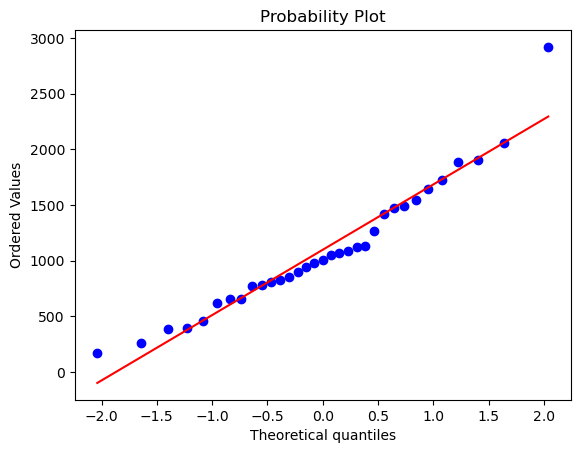

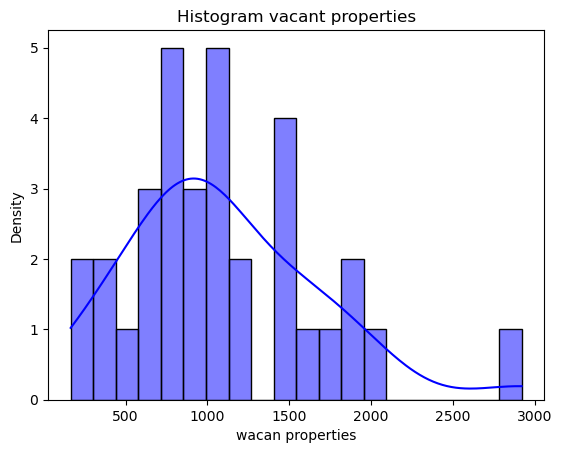

Shapiro-Wilk Test Statistic: 0.9488184332980764
P-value: 0.12287620212550787
Shapiro-Wilk Test Statistic: 0.948758632480925
P-value: 0.12238288672381503


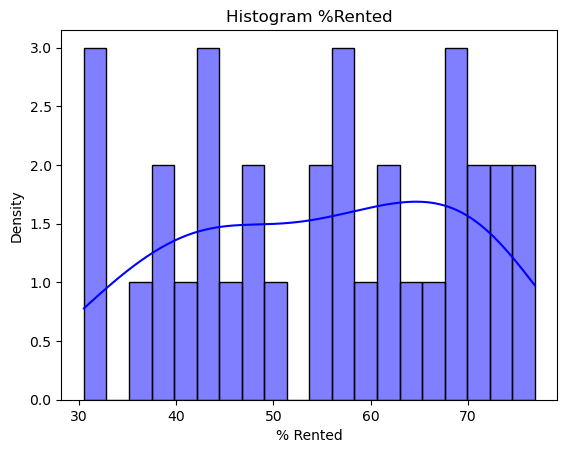

Skewness of Rented: -0.15706738004149598
Skewness of Owned: 0.15761744307702397


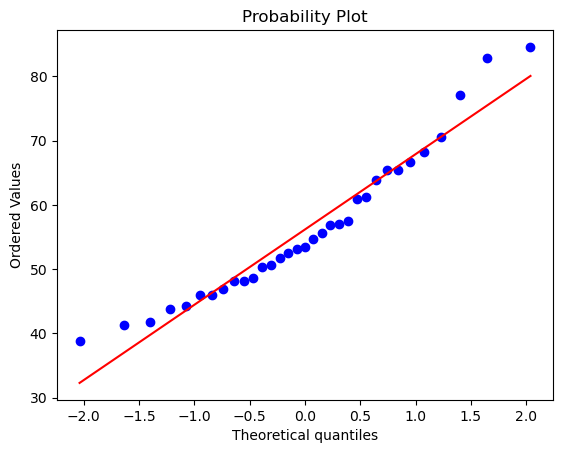

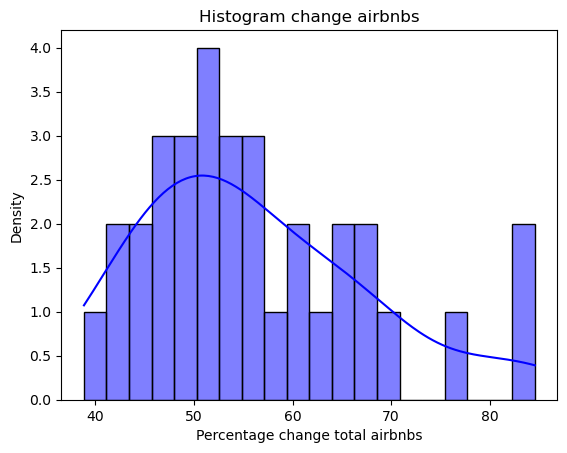

Shapiro-Wilk Test Statistic: 0.9570339752429177
P-value: 0.21278228787968184
Skewness of distance: 0.0657900440473204


'\nFrom all of these normality tests we have decided to transform the change in commercial listings count and the number of vacant \nproperties, not only are they counts but tests for normality, skewness and descriptive visuals show that they are not normally distributed \nwhich may violate the assumptions of a linear relationshio. Likewise by compressing large values it could make the spread of residuals\nmore consistant across the range of data. \nLimitations: overfitting? Potentially changing the interpretation. \n'

In [33]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns


#shapiro wilk test to see if the data is normally distributed
#-------  on the listings data ---------

# Perform the Shapiro-Wilk test
stat, p_value = shapiro(percentage_change_gdf["total_airbnbs"])

# Display the results
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")


#the W values 0.7... is less than 1 (suggesting that the data is not normally distributed) and the p value 0.00000505 is <0.05
#therefore the null hypothesis which assumes that the data is normally distributed is rejected 



# ----------- Perform the test on the '2023' column ------ #
stat, p_value = shapiro(df_vacantprops[2023])
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

#Interpretation 
#0.9465112270729066 W value close to one so its close to normal 
#p value is 0.10520533110791175 greater than 0.05 so we can fail to reject the null hypothesis as there is no significant evidence
#that the data is not normally distributes



# Create Q-Q plot
stats.probplot(df_vacantprops[2023], dist="norm", plot=plt)
plt.show()

#hist to actually visualise the distribution to determine whether we transform or not
# Histogram with a density line
sns.histplot(df_vacantprops[2023], kde=True, color="blue", bins=20)

# Adding labels and title
plt.xlabel('wacan properties')
plt.ylabel('Density')
plt.title('Histogram vacant properties')

# Show plot
plt.show()

#as you can see it is still a bit skewed to the right



#Now we'll do one for the proportion owned and rented 
stat, p_value = shapiro(df_censusTenure['Rented'])
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

#owned
stat, p_value = shapiro(df_censusTenure['Owned'])
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

#hist to actually visualise the distribution to determine whether we transform or not
# Histogram with a density line
sns.histplot(df_censusTenure['Rented'], kde=True, color="blue", bins=20)

# Adding labels and title
plt.xlabel('% Rented')
plt.ylabel('Density')
plt.title('Histogram %Rented')

# Show plot
plt.show()

#it looks asymetrical with a very slight skew so will use further tests to check 

# checking ifits skewed
from scipy.stats import skew

skew_rented = skew(df_censusTenure['Rented'])
skew_owned = skew(df_censusTenure['Owned'])

print(f"Skewness of Rented: {skew_rented}")
print(f"Skewness of Owned: {skew_owned}")

'''
The values are close to 0 althouhh the alues Skewness of Rented: -0.15706738004149598
Skewness of Owned: 0.15761744307702397 suggest a slight skew them being so close to 0 and looking at the hist plots 
and the fact that they are also percentages not counts means that transformation is not necessary
'''


# Create Q-Q plot
stats.probplot(percentage_change_gdf['total_airbnbs'], dist="norm", plot=plt)
plt.show()


# Histogram with a density line
sns.histplot(percentage_change_gdf['total_airbnbs'], kde=True, color="blue", bins=20)

# Adding labels and title
plt.xlabel('Percentage change total airbnbs')
plt.ylabel('Density')
plt.title('Histogram change airbnbs')

# Show plot
plt.show() 


# ------- Checking the normality for distance to centre 

stat, p_value = shapiro(boro['distance_to_midpoint'])
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

#Shapiro-Wilk Test Statistic: 0.9570339752429177 #the value is very close to normal 
#P-value: 0.21278228787968184 #fail to reject the null hypiothesis 

# skew test
skew_dist = skew(boro['distance_to_midpoint'])
print(f"Skewness of distance: {skew_dist}")

#very close to normal and not skewed in a meaningful way 
#Skewness of distance: 0.0657900440473204



'''
From all of these normality tests we have decided to transform the change in commercial listings count and the number of vacant 
properties, not only are they counts but tests for normality, skewness and descriptive visuals show that they are not normally distributed 
which may violate the assumptions of a linear relationshio. Likewise by compressing large values it could make the spread of residuals
more consistant across the range of data. 
Limitations: overfitting? Potentially changing the interpretation. 
'''

**merging the datasets**

In [53]:
import pandas as pd


# Merge using different column names
vacantprops_with_tenure = pd.merge(df_vacantprops[['LAcode', 'LAname', 2023]],  # Fix here
                                   df_censusTenure[['mnemonic', 'Owned', 'Rented']], 
                                   left_on='LAcode',  # Column in df_vacantprops
                                   right_on='mnemonic',  # Column in df_censusTenure
                                   how='inner')

# Print the first few rows of the merged DataFrame
#print(vacantprops_with_tenure.head())



# Merging vacantprops_with_tenure with merged_borough_counts to add Commercial Change
vacantprops_with_tenure_and_commercial = pd.merge(
    vacantprops_with_tenure, 
    counts_first_gdf[['GSS_CODE', 'total_airbnbs']], 
    left_on='LAcode',  # Merge on LAcode from vacantprops_with_tenure
    right_on='GSS_CODE',  # Merge on GSS_CODE from merged_borough_counts
    how='inner'  # Inner join to only keep matching rows
)

# Merging the result with boro to add Distance to Midpoint
final_merged_data = pd.merge(
    vacantprops_with_tenure_and_commercial, 
    boro[['GSS_CODE', 'distance_to_midpoint']], 
    on='GSS_CODE',  # Merge on GSS_CODE which is common
    how='inner'  # Inner join to keep only matching rows
)

# Display the final merged dataframe
#print(final_merged_data)

# Drop the redundant columns (keeping only one column: GSS_CODE)
merged_boroughs_unique = final_merged_data.drop(columns=['GSS_CODE', 'mnemonic'])

# Display the DataFrame after dropping redundant columns
#print(merged_boroughs_unique)

# Merge df_rental_comparison with final_merged_data using the 'LAcode' and 'mnemonic' as keys
final_data_with_rentals = pd.merge(
    final_merged_data,  # previously merged data
    df_rental_comparison[['Mnemonic', 'Price_Difference']],  # relevant columns from df_rental_comparison
    left_on='LAcode',  # Use 'LAcode' from final_merged_data
    right_on='Mnemonic',  # Use 'Mnemonic' from df_rental_comparison
    how='inner'  # Perform an inner join to keep only matching rows
)

# Drop the redundant 'Mnemonic' column after merging
final_data_cleaned = final_data_with_rentals.drop(columns=['GSS_CODE','Mnemonic', 'mnemonic'])

# Display the final merged DataFrame
print(final_data_cleaned)




       LAcode                  LAname    2023  Owned  Rented  total_airbnbs  \
0   E09000002    Barking and Dagenham   383.0   42.4    57.6            133   
1   E09000003                  Barnet  1905.0   52.7    47.4            447   
2   E09000004                  Bexley   655.0   68.6    31.4            123   
3   E09000005                   Brent  1053.0   38.4    61.6            572   
4   E09000006                 Bromley  1068.0   68.5    31.6            202   
5   E09000007                  Camden  1541.0   29.7    70.4           1290   
6   E09000008                 Croydon  1639.0   54.7    45.3            359   
7   E09000009                  Ealing   460.0   46.2    53.8            478   
8   E09000010                 Enfield  1089.0   52.4    47.6            206   
9   E09000011               Greenwich  1123.0   41.1    58.9            439   
10  E09000012                 Hackney   977.0   24.6    75.4           1004   
11  E09000013  Hammersmith and Fulham   778.0   32.1

**Log transforming the data**

       LAcode                  LAname    2023  Owned  Rented  total_airbnbs  \
0   E09000002    Barking and Dagenham   383.0   42.4    57.6            133   
1   E09000003                  Barnet  1905.0   52.7    47.4            447   
2   E09000004                  Bexley   655.0   68.6    31.4            123   
3   E09000005                   Brent  1053.0   38.4    61.6            572   
4   E09000006                 Bromley  1068.0   68.5    31.6            202   
5   E09000007                  Camden  1541.0   29.7    70.4           1290   
6   E09000008                 Croydon  1639.0   54.7    45.3            359   
7   E09000009                  Ealing   460.0   46.2    53.8            478   
8   E09000010                 Enfield  1089.0   52.4    47.6            206   
9   E09000011               Greenwich  1123.0   41.1    58.9            439   
10  E09000012                 Hackney   977.0   24.6    75.4           1004   
11  E09000013  Hammersmith and Fulham   778.0   32.1

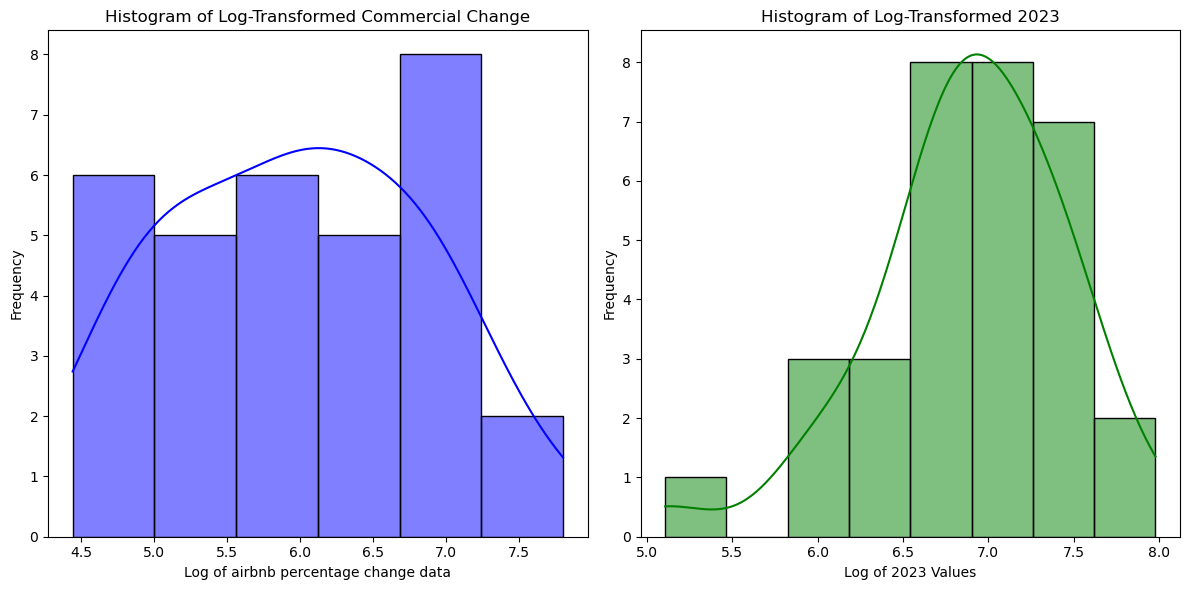

In [60]:
import numpy as np

# sqrt transform the 'Commercial_change' and '2023' columns heteroscedastic
final_data_cleaned['sqrt_airbnb'] = np.sqrt(final_data_cleaned['total_airbnbs'])
final_data_cleaned['log_2023'] = np.log(final_data_cleaned[2023])

final_data_cleaned['log_distance_to_midpoint'] = np.log(final_data_cleaned['distance_to_midpoint'] + 1)  # Add 1 to avoid log(0)
final_data_cleaned['sqrt_pricedif'] = np.sqrt(final_data_cleaned['Price_Difference'] + 1)  # Add 1 to avoid log(0)


#because heteroscedastic

# Display the dataframe after log transformation
print(final_data_cleaned)

## --- doing the shapiro test again on both 
        ## logged commercial data ##
# Perform the Shapiro-Wilk test
stat, p_value = shapiro(final_data_cleaned['log_airbnb'])
## Shapiro-Wilk Test Statistic: 0.9556339522701023
#P-value: 0.20788115435839877

# Display the results
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
##Shapiro-Wilk Test Statistic: 
       ## logged vacant homes/borough
# Perform the Shapiro-Wilk test
stat, p_value = shapiro(final_data_cleaned[2023])

# Display the results
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
## Shapiro-Wilk Test Statistic: 0.9525811247269396
# P-value: 0.17056281859711886

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure for the histograms
plt.figure(figsize=(12, 6))

# Plot histogram for log-transformed Commercial Change
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(final_data_cleaned['log_airbnb'], kde=True, color='blue')
plt.title('Histogram of Log-Transformed Commercial Change')
plt.xlabel('Log of airbnb percentage change data')
plt.ylabel('Frequency')

# Plot histogram for log-transformed 2023 values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(final_data_cleaned['log_2023'], kde=True, color='green')
plt.title('Histogram of Log-Transformed 2023')
plt.xlabel('Log of 2023 Values')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

## its good enough ## hopefully it wont skew the resid 


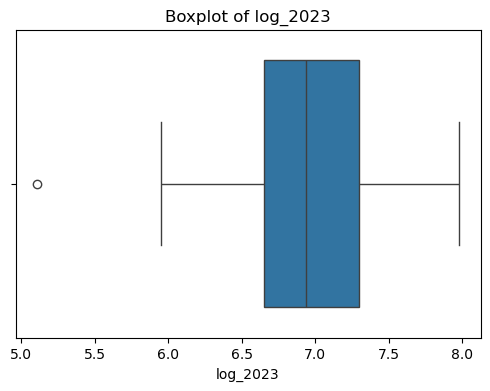

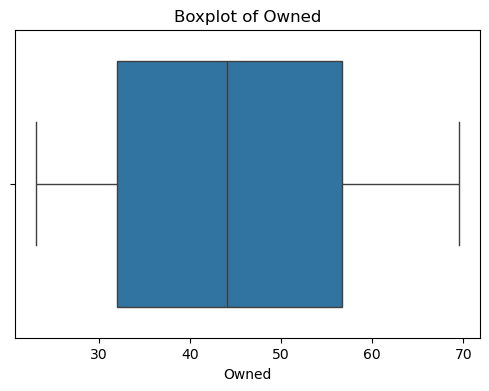

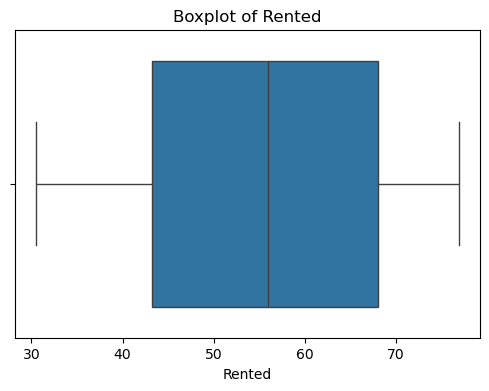

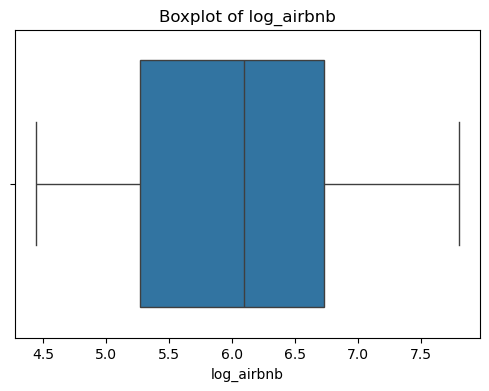

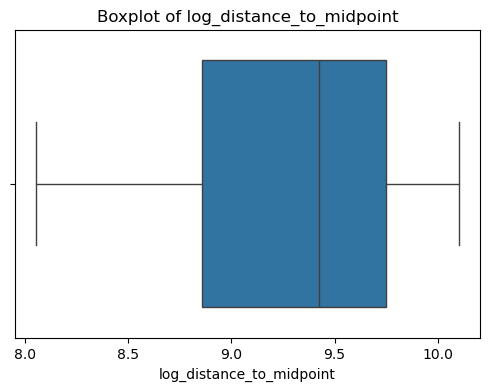

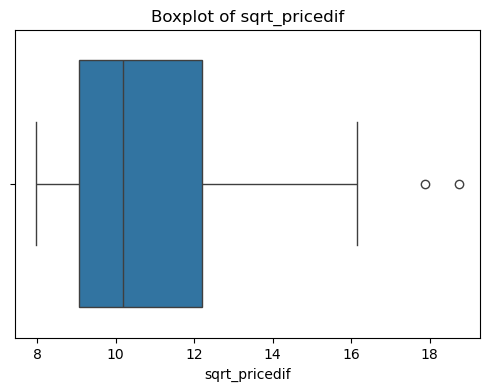

In [61]:
## checking for outliers and removing them after seeing that the residuals vs fitted plot is no normal
## scattered around 0
import matplotlib.pyplot as plt
import seaborn as sns

# List of variables to check for outliers
vars_ = ['log_2023', 'Owned', 'Rented', 'log_airbnb', 'log_distance_to_midpoint', 'sqrt_pricedif']

# boxplots for each variable
for var in vars_:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=final_data_cleaned[var])
    plt.title(f'Boxplot of {var}')
    plt.show()
#as you can see there are outliers present even after transforming which may impact the models functionality

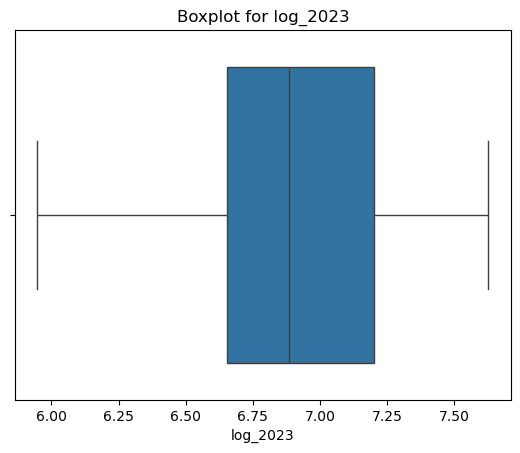

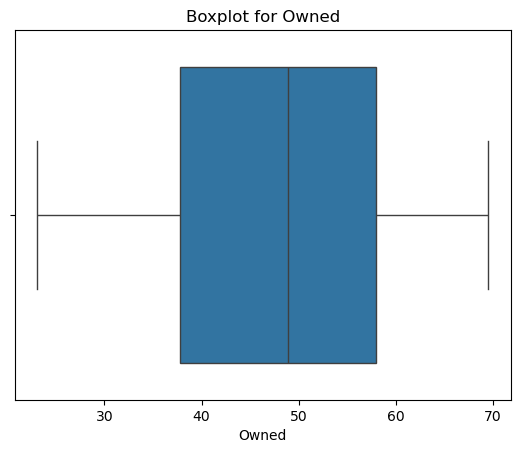

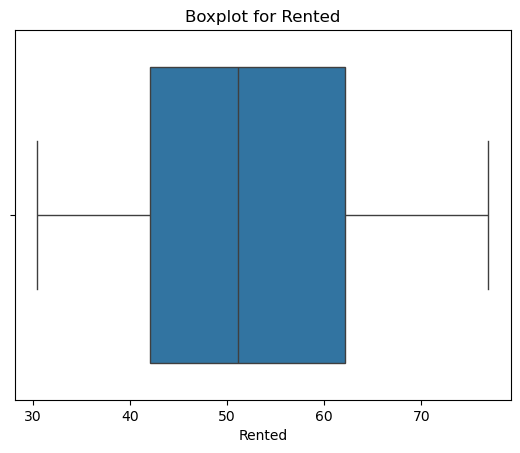

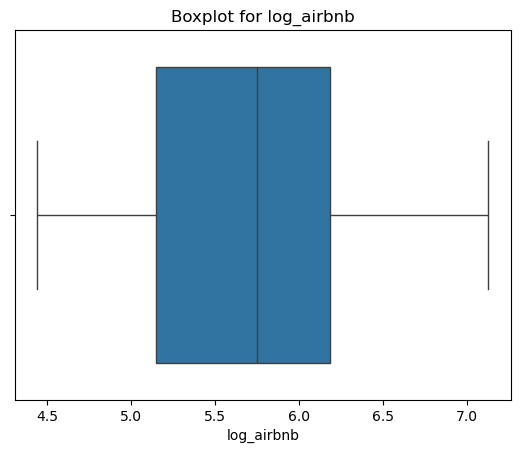

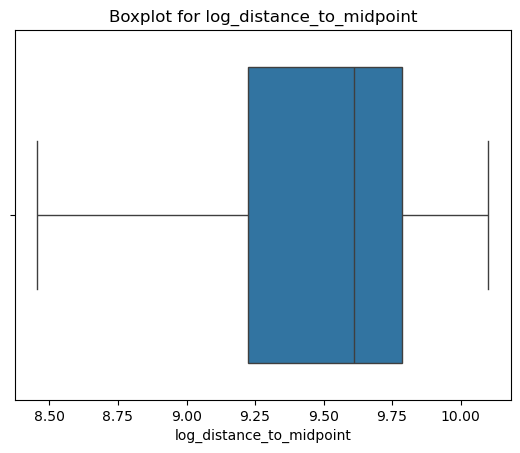

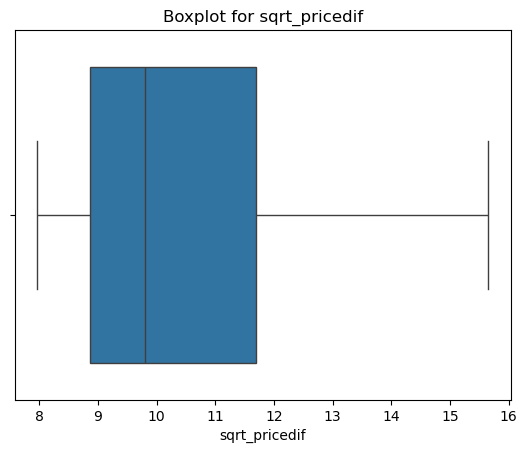

       LAcode                  LAname    2023  Owned  Rented  total_airbnbs  \
0   E09000002    Barking and Dagenham   383.0   42.4    57.6            133   
1   E09000003                  Barnet  1905.0   52.7    47.4            447   
2   E09000004                  Bexley   655.0   68.6    31.4            123   
3   E09000005                   Brent  1053.0   38.4    61.6            572   
4   E09000006                 Bromley  1068.0   68.5    31.6            202   
6   E09000008                 Croydon  1639.0   54.7    45.3            359   
7   E09000009                  Ealing   460.0   46.2    53.8            478   
8   E09000010                 Enfield  1089.0   52.4    47.6            206   
9   E09000011               Greenwich  1123.0   41.1    58.9            439   
10  E09000012                 Hackney   977.0   24.6    75.4           1004   
11  E09000013  Hammersmith and Fulham   778.0   32.1    67.9            828   
12  E09000014                Haringey  1468.0   37.2

In [67]:
# Calculate Q1, Q3, and IQR for each numeric column - makes sense to do it this way because i displayed the outliers in a boxplot 
#initally

# Select only numeric columns because it won't work for a string 
numeric_cols = final_data_cleaned.select_dtypes(include=['float64', 'int64'])

Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Define bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows in numeric columns that are within bounds
mask = ~((numeric_cols < lower_bound) | (numeric_cols > upper_bound)).any(axis=1)

# Use the mask to filter the original DataFrame
final_data_cleaned_no_outliers = final_data_cleaned[mask]



#print(final_data_cleaned_no_outliers)

## --------- rechecking 
import matplotlib.pyplot as plt
import seaborn as sns

for var in vars_:
    sns.boxplot(x=final_data_cleaned_no_outliers[var])
    plt.title(f"Boxplot for {var}")
    plt.show()

print(final_data_cleaned_no_outliers)


                            OLS Regression Results                            
Dep. Variable:          sqrt_pricedif   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     20.81
Date:                Sat, 07 Dec 2024   Prob (F-statistic):           9.59e-07
Time:                        22:41:32   Log-Likelihood:                -40.150
No. Observations:                  27   AIC:                             88.30
Df Residuals:                      23   BIC:                             93.48
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

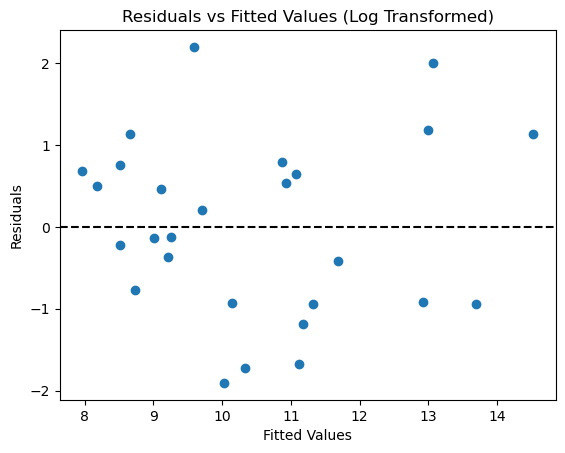

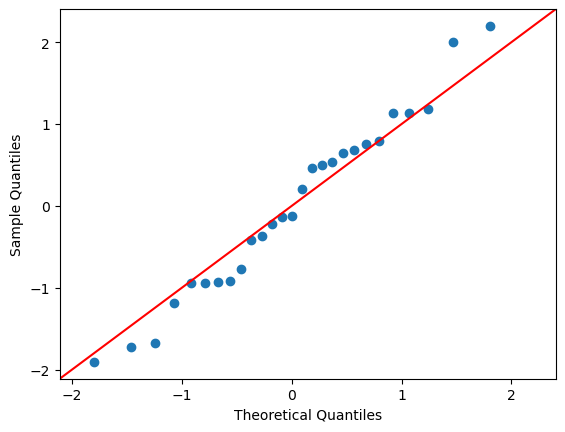

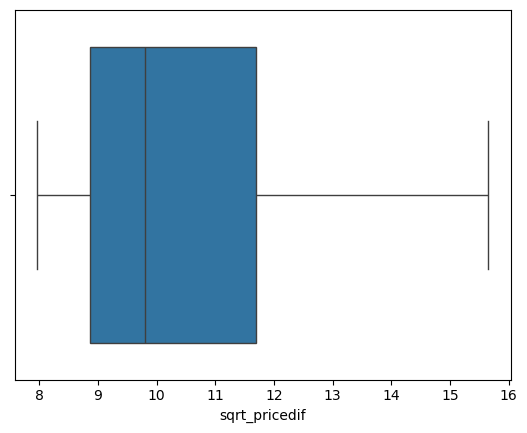

Breusch-Pagan p-value: 0.6103024667500756
White test p-value: 0.2374149285972516


In [87]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Re-run the regression model with transformed dependent variable
X = final_data_cleaned_no_outliers[['sqrt_airbnb','log_2023','distance_to_midpoint_km']]  # Example of log transformation
y = final_data_cleaned_no_outliers['sqrt_pricedif']  # Log-transformed dependent variable

final_data_cleaned_no_outliers.loc[:, 'distance_to_midpoint_km'] = final_data_cleaned_no_outliers['distance_to_midpoint'] / 1000
#the scale should not dominate others numerically 

# Fit the model
model_log = sm.OLS(y, sm.add_constant(X)).fit()

# Display model summary
print(model_log.summary())

# Plot residuals after the transformation
residuals_log = model_log.resid
fitted_values_log = model_log.fittedvalues

# Residuals vs Fitted plot
plt.scatter(fitted_values_log, residuals_log)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals vs Fitted Values (Log Transformed)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

# QQ plot
sm.qqplot(residuals_log, line='45')
plt.show()

# Check for outliers with boxplot
sns.boxplot(x=final_data_cleaned_no_outliers['sqrt_pricedif'])  # Check outliers in the dependent variable
plt.show()

# Recheck for normality with other transformations or model adjustments.

import statsmodels.stats.api as sms

# Breusch-Pagan test for heteroskedasticity
_, p_value, _, _ = sms.het_breuschpagan(residuals_log, model_log.model.exog)
print(f'Breusch-Pagan p-value: {p_value}')

from statsmodels.stats.diagnostic import het_white

# White test for heteroskedasticity
_, p_value, _, _ = het_white(residuals_log, model_log.model.exog)
print(f'White test p-value: {p_value}')



# Model Interpretation
> Breusch-Pagan p-value: 0.6103024667500756
White test p-value: 0.2374149285972516 --- for both of these tests the null hypothesis is homoskedasticity and since the p values are above 0.05 - we fail to reject the null hypothesis. There is no strong evidence that the residuals are heteroskedastic.

> R-squared of 0.731 means that 73.1% of the variation in the dependent variable is explained by the model.

> However, since the Adjusted R-squared is 0.696 it indicates the predictors are contributing meaningfully, so overfitting is less likely because it also includes the non statistically significant predictors.
>  Overfitting happens when Overfitting happens when you include too many irrelevant predictors in the model. While R-squared
  will always go up, Adjusted R-squared will drop if the predictors are not useful.


**The model as a whole**
> The F statistic: 20.81 is high suggesting that the predictors are doing a good job at explaining the outcome.
> The p value of 0.000000959 is very low (almost zero) suggesting that the model as a whole is highly statistically significant.

**the coefficients**
**Airbnb Listings (Transformed):**

> The coefficient for airbnb is 0.2534.
This means that as the number of Airbnb listings increases (after applying the square root transformation), the square root of the price difference increases by 0.2534.
To get the real price difference, square the 0.2534. So, a small increase in Airbnb listings will increase the actual price difference by about 0.0643.

**Year (2023, Transformed):**

>The coefficient for log 2023 is -0.1946.
This means that as 2023 increases (in the log scale), the square root of the price difference decreases by 0.1946.
The actual price difference decreases by 0.0379.

**Distance to Midpoint (Transformed):**

> The coefficient for distance to midpoint is -0.0023.
This means as the distance to the midpoint increases, the square root of the price difference decreases slightly.
To get the real price difference, square the coefficient. The change in the actual price difference is very small: 0.000005



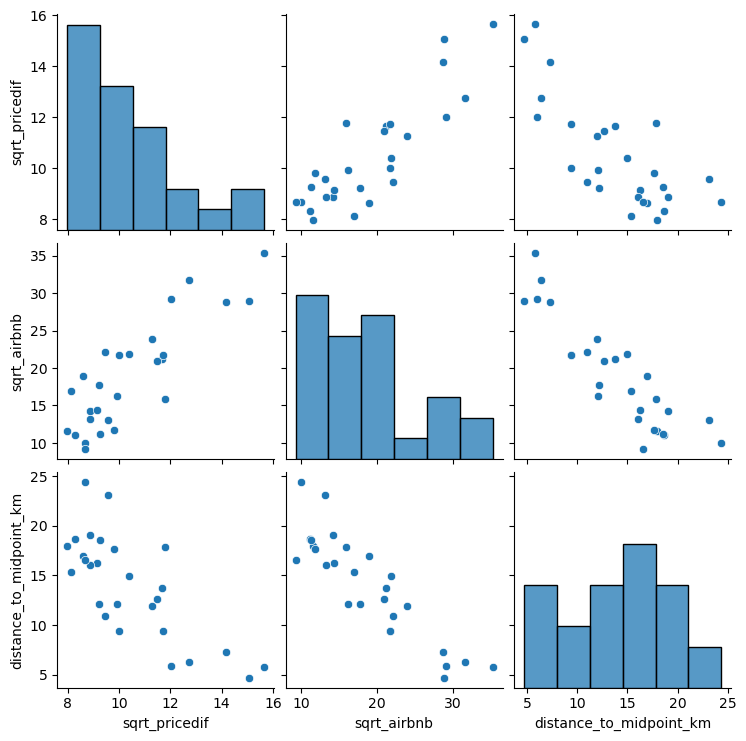

In [89]:
#trying to fitthe model assumtions
#checking if the relationshipis linear 
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for each independent variable vs Price_Difference
sns.pairplot(final_data_cleaned_no_outliers[['sqrt_pricedif', 'sqrt_airbnb', 'distance_to_midpoint_km']])
plt.show()



In [84]:
#checking the VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the independent variables for VIF calculation
X_with_const = add_constant(X)

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF values
print(vif_data)


               Variable         VIF
0                 const  446.029069
1           sqrt_airbnb    4.836356
2              log_2023    1.172669
3  distance_to_midpoint    4.966716


In [80]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = final_data_cleaned[['sqrt_airbnb', 'distance_to_midpoint', 'Rented']]
while True:
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)

    # Stop if all VIFs are below the threshold
    if vif['VIF'].max() < 5:
        break

    # Drop the variable with the highest VIF
    X = X.drop(columns=vif.loc[vif['VIF'].idxmax(), 'Variable'])



               Variable        VIF
0           sqrt_airbnb  25.438741
1  distance_to_midpoint   3.924910
2                Rented  36.094605
               Variable       VIF
0           sqrt_airbnb  1.883882
1  distance_to_midpoint  1.883882
